<a href="https://colab.research.google.com/github/Sayandip2023/Final-Year-Project-Code/blob/main/Pneumonia_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports and Installs

In [1]:
# --- Step 1: Install Kaggle and setup API ---
!pip install -q kaggle
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import os
import zipfile

# Make sure kaggle.json is uploaded to /content/
os.makedirs('/root/.kaggle/', exist_ok=True)
!cp kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

# --- Step 2: Download dataset from Kaggle ---
# Dataset URL: https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

# --- Step 3: Unzip the dataset ---
with zipfile.ZipFile('chest-xray-pneumonia.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')


Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 99% 2.27G/2.29G [00:20<00:00, 42.5MB/s]
100% 2.29G/2.29G [00:20<00:00, 123MB/s] 


## Loading and Preprocessing The Data

In [22]:
# Use 10% of training data for validation
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.1)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(64,64),
    batch_size=32,
    class_mode='binary',
    subset='training',
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(64,64),
    batch_size=32,
    class_mode='binary',
    subset='validation',
    shuffle=False
)


Found 4695 images belonging to 2 classes.
Found 521 images belonging to 2 classes.


## Building The Model

In [14]:
input_shape = (64, 64, 3)
num_classes = 2

# Change the output layer for binary classification
model = Sequential()

# Block 1
model.add(Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.25))

# Block 2
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.25))

# Block 3
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(GlobalAveragePooling2D())  # instead of maxpooling here
model.add(Dropout(0.4))

# Dense layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))  # Change this to 1 output with sigmoid

# Compile model with binary cross-entropy loss
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 102,465 (400.25 KB)

 Trainable params: 102,017 (398.50 KB)

 Non-trainable params: 448 (1.75 KB)

## Training The Model

In [15]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=3)

history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[reduce_lr]
)


Epoch 1/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.7957 - loss: 0.4192

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


147/147 ━━━━━━━━━━━━━━━━━━━━ 57s 335ms/step - accuracy: 0.7962 - loss: 0.4185 - val_accuracy: 0.7428 - val_loss: 2.9246 - learning_rate: 0.0010
Epoch 2/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 43s 294ms/step - accuracy: 0.9274 - loss: 0.1996 - val_accuracy: 0.7428 - val_loss: 3.5070 - learning_rate: 0.0010
Epoch 3/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 83s 298ms/step - accuracy: 0.9480 - loss: 0.1382 - val_accuracy: 0.7428 - val_loss: 2.6891 - learning_rate: 0.0010
Epoch 4/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 42s 287ms/step - accuracy: 0.9576 - loss: 0.1181 - val_accuracy: 0.9232 - val_loss: 0.1936 - learning_rate: 0.0010
Epoch 5/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 43s 294ms/step - accuracy: 0.9653 - loss: 0.0982 - val_accuracy: 0.7428 - val_loss: 1.5483 - learning_rate: 0.0010
Epoch 6/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 82s 296ms/step - accuracy: 0.9656 - loss: 0.0996 - val_accuracy: 0.9635 - val_loss: 0.1132 - learning_rate: 0.0010
Epoch 7/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 42s 284ms/step - accuracy: 0.9633 - loss:

## Evaluation Of Model On The Test Data

In [16]:
# Assuming you have a separate test directory (or test data in the validation generator)
test_dir = '/content/chest_xray/test'

# Test Generator
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Test Loss: {test_loss:.2f}")


Found 624 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 204ms/step - accuracy: 0.4737 - loss: 2.6875
Test Accuracy: 71.63%
Test Loss: 1.51


## Training And Validation Curves

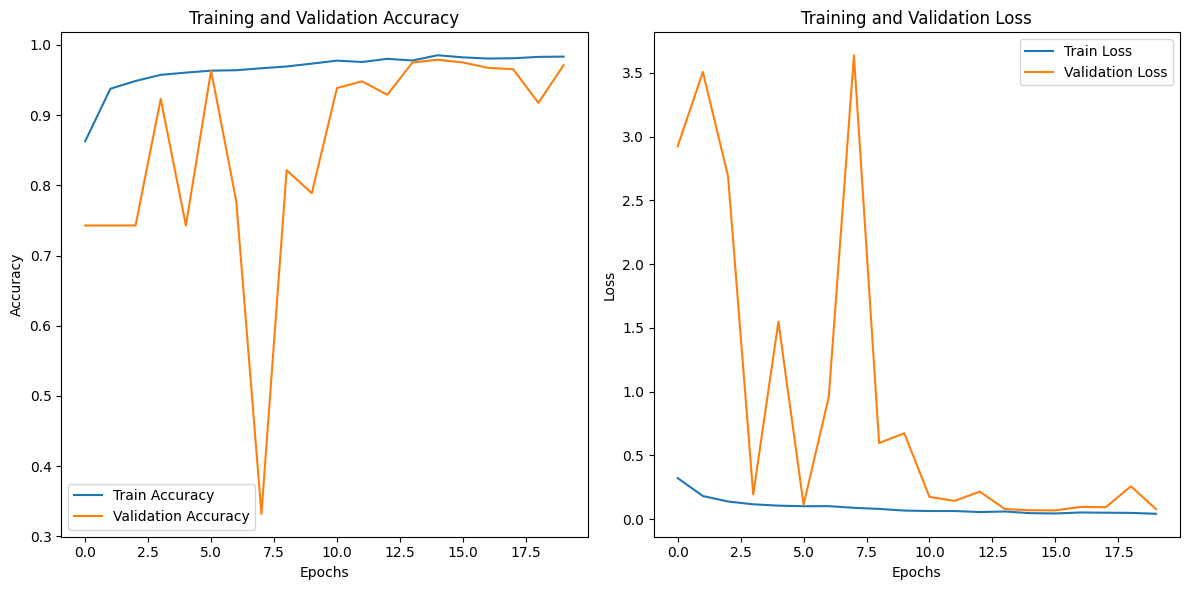

In [17]:
# Plot training & validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


## Classification Report

In [18]:
# Predict on the test set
y_pred = model.predict(test_generator, verbose=1)
y_pred = (y_pred > 0.5)  # Convert probabilities to binary predictions

# Get true labels
y_true = test_generator.classes

# Generate classification report
print(classification_report(y_true, y_pred))

20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 205ms/step
              precision    recall  f1-score   support

           0       0.98      0.25      0.40       234
           1       0.69      1.00      0.81       390

    accuracy                           0.72       624
   macro avg       0.84      0.62      0.61       624
weighted avg       0.80      0.72      0.66       624



## Confusion Matrix

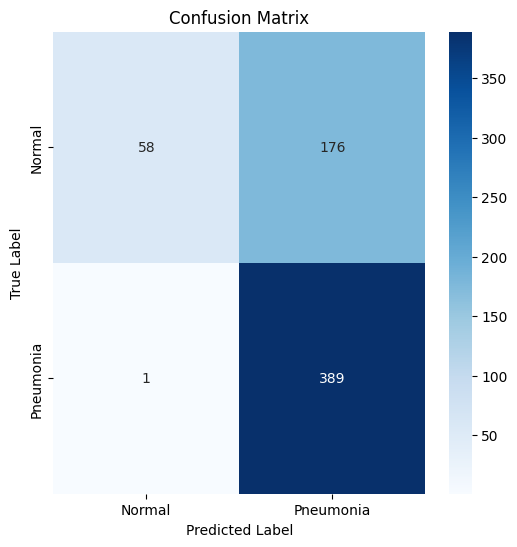

In [19]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


## Saving The Model

In [21]:
model.save('model.keras')